In [ ]:
# =========================================================
# COMPLETE PROJECT: NYC Taxi Fare Prediction using PySpark MLlib
# =========================================================
from pyspark.sql import SparkSession
from pyspark.sql.functions import sin, cos, asin, sqrt, radians, col, when, lit, hour, dayofweek, month, unix_timestamp, to_timestamp, count, isnan, min, max, avg, stddev, expr
from pyspark.sql.types import DoubleType, IntegerType, TimestampType
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression, DecisionTreeRegressor, GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql.window import Window
from math import radians, sin, cos, asin, sqrt, atan2, degrees

import sys

print("="*80)
print("NYC TAXI FARE PREDICTION - PySpark MLlib Complete Implementation")
print("="*80)

NYC TAXI FARE PREDICTION - PySpark MLlib Complete Implementation


In [2]:
# =========================================================
# CELL 2: BUAT SPARK SESSION 
# =========================================================
# BUAT SPARK SESSION 
spark = SparkSession.builder \
    .appName("NYC_Taxi_Fare_Prediction_Final") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()
    
# WAJIB! Fix error 'u' pattern datetime di Spark 3.4+
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

spark.sparkContext.setLogLevel("WARN")
print("SPARK SESSION + LEGACY DATETIME BERHASIL!")

spark.sparkContext.setLogLevel("WARN")
print("SPARK SESSION BERHASIL DIBUAT!")
print(f"Spark Version: {spark.version}")
print(f"App Name     : {spark.conf.get('spark.app.name')}")

SPARK SESSION + LEGACY DATETIME BERHASIL!
SPARK SESSION BERHASIL DIBUAT!
Spark Version: 3.5.7
App Name     : NYC_Taxi_Fare_Prediction_Final


In [3]:
# ---------------------------
# 2. LOAD DATA (Data Loading & Preparation)
# ---------------------------
data_path = "train.csv"  # Sesuaikan path
sample_fraction = 0.05  # Ubah ke 1.0 untuk full dataset

# 1. Baca data + sample SEKALIGUS (lebih efisien)
df = spark.read.csv(data_path, header=True, inferSchema=True) \
          .sample(withReplacement=False, fraction=sample_fraction, seed=42) \
          .cache()  # Tambah .cache() biar cepat

print(f"Original dataset berhasil dimuat!")
print(f"Sampled dataset: {df.count():,} baris ({sample_fraction*100:.1f}%)")

print("\n[Data Schema]")
df.printSchema()

print("\n[First 5 rows]")
df.show(5, truncate=False)

# Required columns
required_cols = ["pickup_datetime", "pickup_longitude", "pickup_latitude",
                 "dropoff_longitude", "dropoff_latitude", "passenger_count", "fare_amount"]

# Type casting (PAKAI from pyspark.sql.types import IntegerType, DoubleType)
print("\n[Type Casting]")
df = df.withColumn("passenger_count", col("passenger_count").cast("integer")) \
       .withColumn("fare_amount", col("fare_amount").cast("double")) \
       .withColumn("pickup_longitude", col("pickup_longitude").cast("double")) \
       .withColumn("pickup_latitude", col("pickup_latitude").cast("double")) \
       .withColumn("dropoff_longitude", col("dropoff_longitude").cast("double")) \
       .withColumn("dropoff_latitude", col("dropoff_latitude").cast("double"))
print("Type casting selesai")

# Drop nulls di kolom penting
df = df.dropna(subset=required_cols)
print(f"Setelah drop nulls: {df.count():,} baris")

# Filter koordinat NYC (batas lebih ketat biar lebih bersih)
df = df.filter(
    (col("pickup_longitude").between(-75, -73)) &
    (col("pickup_latitude").between(40, 42)) &
    (col("dropoff_longitude").between(-75, -73)) &
    (col("dropoff_latitude").between(40, 42))
)
print(f"Setelah filter koordinat NYC: {df.count():,} baris")

# Filter fare_amount dan passenger_count realistis
df = df.filter(
    (col("fare_amount") >= 2.5) & (col("fare_amount") <= 300) &
    (col("passenger_count").between(1, 6))
)
print(f"Setelah filter fare & penumpang: {df.count():,} baris")

Original dataset berhasil dimuat!
Sampled dataset: 2,770,820 baris (5.0%)

[Data Schema]
root
 |-- key: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)


[First 5 rows]
+----------------------------+-----------+-----------------------+----------------+---------------+-----------------+----------------+---------------+
|key                         |fare_amount|pickup_datetime        |pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+----------------------------+-----------+-----------------------+----------------+---------------+-----------------+----------------+---------------+
|2014-02-19 07:22:00.00000074|12.5       |2014-02-19 07:22:00 UTC|-73.9

In [ ]:
# ---------------------------
# 3. EXPLORATORY DATA ANALYSIS 
# ---------------------------
# 3.1 Statistik Deskriptif
print("\n[3.1] Statistik Deskriptif")
numeric_cols = ["fare_amount", "passenger_count", "pickup_longitude", "pickup_latitude", 
                "dropoff_longitude", "dropoff_latitude"]

# Gunakan .toPandas() untuk tampilan tabel yang lebih baik dan interaktif
df.describe(numeric_cols).toPandas()

# 3.2 Analisis Missing Values
print("\n[3.2] Analisis Missing Values + NaN")

from pyspark.sql.functions import col, when, count, isnan, min, max, avg, stddev, expr

total_rows = df.count()
print(f"Total baris setelah pembersihan: {total_rows:,}")

print("\nNilai yang Hilang (Null + NaN):")
print("-" * 55)

for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    try:
        nan_count = df.filter(col(column).cast("double").isNaN()).count()
    except:
        nan_count = 0
    
    total_missing = null_count + nan_count
    if total_missing > 0:
        print(f"{column:25} → {total_missing:7,} hilang  ({total_missing/total_rows*100:5.2f}%)")

print("-" * 55)
print("Analisis missing value selesai!\n")

# 3.3 Analisis Distribusi Jumlah Tarif
print("\n[3.3] Distribusi Jumlah Tarif")
fare_stats = df.agg(
    min("fare_amount").alias("Min"),
    max("fare_amount").alias("Max"),
    avg("fare_amount").alias("Mean"),
    expr("percentile_approx(fare_amount, 0.25)").alias("Q1"),
    expr("percentile_approx(fare_amount, 0.5)").alias("Median"),
    expr("percentile_approx(fare_amount, 0.75)").alias("Q3"),
    stddev("fare_amount").alias("StdDev")
)
# Tampilkan sebagai Pandas DataFrame
fare_stats.toPandas()

# 3.4 Analisis Distribusi Jumlah Penumpang
print("\n[3.4] Distribusi Jumlah Penumpang")
passenger_stats = df.groupBy("passenger_count").agg(
    count("*").alias("Count"),
    avg("fare_amount").alias("Avg_Fare"),
    min("fare_amount").alias("Min_Fare"),
    max("fare_amount").alias("Max_Fare")
).orderBy("passenger_count")
# Tampilkan sebagai Pandas DataFrame
passenger_stats.toPandas()

# 3.5 Analisis Data Duplikat
print("\n[3.5] Analisis Data Duplikat")
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Total baris duplikat: {duplicate_count}")
print(f"Persentase duplikat: {(duplicate_count/df.count())*100:.2f}%")

# 3.6 Analisis Distribusi Tipe Data
print("\n[3.6] Distribusi Tipe Data")
print(f"Total kolom: {len(df.columns)}")
print(f"Kolom numerik: {len(numeric_cols)}")
print(f"Kolom kategorikal: {len(df.columns) - len(numeric_cols)}")

print("\nEDA Selesai")


[3.1] Statistik Deskriptif

[3.2] Analisis Missing Values + NaN
Total baris setelah pembersihan: 2,702,824

Nilai yang Hilang (Null + NaN):
-------------------------------------------------------
-------------------------------------------------------
Analisis missing value selesai!


[3.3] Distribusi Jumlah Tarif

[3.4] Distribusi Jumlah Penumpang

[3.5] Analisis Data Duplikat
Total baris duplikat: 0
Persentase duplikat: 0.00%

[3.6] Distribusi Tipe Data
Total kolom: 8
Kolom numerik: 6
Kolom kategorikal: 2

EDA Selesai


In [ ]:
# ============================================================
# [4] FEATURE ENGINEERING 
# ============================================================
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import numpy as np

# -------------------------------
# Ini untuk mencegah error "Column already exists" saat menjalankan ulang cell ini
# -------------------------------
print("Membersihkan kolom cluster dari proses sebelumnya...")
if "pickup_cluster" in df.columns:
    df = df.drop("pickup_cluster")
if "dropoff_cluster" in df.columns:
    df = df.drop("dropoff_cluster")
print("Pembersihan selesai.")


# -------------------------------
# Haversine langsung pakai SQL expression
# -------------------------------
df = df.withColumn("pickup_datetime_ts", to_timestamp("pickup_datetime"))

df = df.withColumn("lat1", radians(col("pickup_latitude"))) \
       .withColumn("lon1", radians(col("pickup_longitude"))) \
       .withColumn("lat2", radians(col("dropoff_latitude"))) \
       .withColumn("lon2", radians(col("dropoff_longitude")))

df = df.withColumn("dlat", col("lat2") - col("lat1")) \
       .withColumn("dlon", col("lon2") - col("lon1"))

df = df.withColumn("a", 
    sin(col("dlat")/2)**2 + 
    cos(col("lat1")) * cos(col("lat2")) * sin(col("dlon") / 2)**2
)

df = df.withColumn("haversine_km", 
    when(col("a").isNotNull(), 
         2 * 6371 * asin(sqrt(col("a")))
    ).otherwise(0.001)
)

# Manhattan 
df = df.withColumn("manhattan_km", 
    abs(col("dropoff_longitude") - col("pickup_longitude")) * 111.32 * cos(radians((col("pickup_latitude") + col("dropoff_latitude")) / 2)) +
    abs(col("dropoff_latitude") - col("pickup_latitude")) * 111.32
)

# Drop kolom sementara
df = df.drop("lat1","lon1","lat2","lon2","dlat","dlon","a")

print("Fitur jarak: haversine_km, manhattan_km = selesai")

# -------------------------------
# 2. Temporal Features (semua built-in)
# -------------------------------
df = df.withColumn("hour", hour("pickup_datetime_ts")) \
       .withColumn("day_of_week", dayofweek("pickup_datetime_ts")) \
       .withColumn("is_weekend", when(dayofweek("pickup_datetime_ts").isin(1,7), 1).otherwise(0)) \
       .withColumn("month", month("pickup_datetime_ts"))

# Trip duration (kalau ada dropoff)
if "dropoff_datetime" in df.columns:
    df = df.withColumn("trip_seconds", 
        (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime_ts")).cast("double")
    )
else:
    df = df.withColumn("trip_seconds", lit(-1.0))

df = df.withColumn("trip_seconds", when(col("trip_seconds").isNull() | (col("trip_seconds") <= 0), 600.0).otherwise(col("trip_seconds")))

print("Fitur temporal + durasi perjalanan selesai!")

# -------------------------------
# 3. KMEANS CLUSTER
# -------------------------------
print("Melatih KMeans untuk lokasi pickup & dropoff (k=15)")

# Assembly vector untuk PICKUP
assembler_pickup = VectorAssembler(
    inputCols=["pickup_longitude", "pickup_latitude"],
    outputCol="pickup_loc_features",
    handleInvalid="skip"
)

# Assembly vector untuk DROPOFF
assembler_dropoff = VectorAssembler(
    inputCols=["dropoff_longitude", "dropoff_latitude"],
    outputCol="dropoff_loc_features",
    handleInvalid="skip"
)

# Buat model KMeans 
kmeans_pickup = KMeans(k=15, seed=42, featuresCol="pickup_loc_features", predictionCol="pickup_cluster", maxIter=20)
kmeans_dropoff = KMeans(k=15, seed=42, featuresCol="dropoff_loc_features", predictionCol="dropoff_cluster", maxIter=20)

# Pipeline untuk pickup
pipeline_pickup = Pipeline(stages=[assembler_pickup, kmeans_pickup])
model_pickup = pipeline_pickup.fit(df)

# Pipeline untuk dropoff
pipeline_dropoff = Pipeline(stages=[assembler_dropoff, kmeans_dropoff])
model_dropoff = pipeline_dropoff.fit(df)

# Transform langsung tanpa perlu rename lagi
df = model_pickup.transform(df)
df = model_dropoff.transform(df)

print("Clustering selesai! pickup_cluster & dropoff_cluster siap digunakan!")

# -------------------------------
# 4. Final Cleanup
# -------------------------------
# Hapus kolom fitur lokasi yang tidak lagi diperlukan
df = df.drop("pickup_loc_features", "dropoff_loc_features")

df = df.fillna({
    "haversine_km": 0.001,
    "manhattan_km": 0.001,
    "trip_seconds": 600,
    "pickup_cluster": -1,
    "dropoff_cluster": -1
})

# Cache biar cepat dipakai nanti
df.cache()
print(f"Feature engineering selesai! Total baris: {df.count():,}")

# -------------------------------
# 5. Daftar fitur final (untuk VectorAssembler nanti)
# -------------------------------
final_features = [
    "haversine_km", "manhattan_km",
    "passenger_count", "trip_seconds",
    "hour", "day_of_week", "is_weekend",
    "pickup_cluster", "dropoff_cluster"
]
print("\nDaftar fitur final untuk modeling:")
print(final_features)

Membersihkan kolom cluster dari proses sebelumnya...
Pembersihan selesai.
Fitur jarak: haversine_km, manhattan_km = selesai
Fitur temporal + durasi perjalanan selesai!
Melatih KMeans untuk lokasi pickup & dropoff (k=15)
Clustering selesai! pickup_cluster & dropoff_cluster siap digunakan!
Feature engineering selesai! Total baris: 2,702,824

Daftar fitur final untuk modeling:
['haversine_km', 'manhattan_km', 'passenger_count', 'trip_seconds', 'hour', 'day_of_week', 'is_weekend', 'pickup_cluster', 'dropoff_cluster']


In [ ]:
# ---------------------------
# 5. DATA PREPROCESSING
# ---------------------------
# --- DAFTAR FITUR YANG AKAN DIGUNAKAN ---
# Fitur Numerik (akan di-scaling)
numeric_features = [
    "haversine_km", 
    "manhattan_km", 
    "passenger_count", 
    "trip_seconds"
]

# Fitur Kategorikal (akan di-index dan di-encode)
categorical_cols = [
    "pickup_cluster", 
    "dropoff_cluster", 
    "hour", 
    "day_of_week", 
    "is_weekend", 
    "month"
]

print(f"\nFitur Numerik ({len(numeric_features)}): {numeric_features}")
print(f"Fitur Kategorikal ({len(categorical_cols)}): {categorical_cols}")

# --- MEMBANGUN PIPELINE PREPROCESSING ---
stages = []

# Langkah 1: StringIndexer untuk setiap fitur kategorikal
# Mengubah teks/angka kategori menjadi indeks numerik (dimulai dari 0)
print("\nMelakukan StringIndexer pada fitur kategorikal...")
for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_idx", handleInvalid="keep")
    stages.append(indexer)

# Langkah 2: OneHotEncoder untuk fitur yang sudah di-index
# Mengubah indeks numerik menjadi vektor biner
print("Melakukan OneHotEncoder pada fitur yang sudah di-index...")
for col_name in categorical_cols:
    encoder = OneHotEncoder(inputCol=col_name + "_idx", outputCol=col_name + "_ohe", handleInvalid="keep")
    stages.append(encoder)

# Langkah 3: VectorAssembler untuk menggabungkan semua fitur
# Menggabungkan fitur numerik dan fitur kategorikal (yang sudah OHE) menjadi satu vektor fitur
ohe_cols = [c + "_ohe" for c in categorical_cols]
final_feature_cols = numeric_features + ohe_cols

print(f"\nTotal kolom fitur setelah encoding: {len(final_feature_cols)}")
assembler = VectorAssembler(inputCols=final_feature_cols, outputCol="features_raw", handleInvalid="keep")
stages.append(assembler)

# Langkah 4: StandardScaler untuk menstandarisasi fitur
# Menskalakan fitur agar memiliki rata-rata 0 dan standar deviasi 1
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
stages.append(scaler)

# --- MENJALANKAN PIPELINE ---
print("\nMemulai proses preprocessing pipeline...")
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

# --- MEMILIH DATASET AKHIR UNTUK MODELING ---
df_ready = df_transformed.select("features", "fare_amount").cache()

print("\nPreprocessing selesai!")
print(f"Dimensi vektor fitur akhir: {len(df_ready.select('features').first()['features'])}")
print(f"Dataset siap untuk modeling: {df_ready.count()} baris")
print("="*80)


Fitur Numerik (4): ['haversine_km', 'manhattan_km', 'passenger_count', 'trip_seconds']
Fitur Kategorikal (6): ['pickup_cluster', 'dropoff_cluster', 'hour', 'day_of_week', 'is_weekend', 'month']

Melakukan StringIndexer pada fitur kategorikal...
Melakukan OneHotEncoder pada fitur yang sudah di-index...

Total kolom fitur setelah encoding: 10

Memulai proses preprocessing pipeline...

Preprocessing selesai!
Dimensi vektor fitur akhir: 85
Dataset siap untuk modeling: 2702824 baris


In [8]:
# ---------------------------
# 6. TRAIN-TEST SPLIT
# ---------------------------
train_df, test_df = df_ready.randomSplit([0.8, 0.2], seed=42)
print(f"\nTrain set: {train_df.count()} baris (80%)")
print(f"Test set: {test_df.count()} baris (20%)")

train_df.cache()
test_df.cache()


Train set: 2161098 baris (80%)
Test set: 541726 baris (20%)


DataFrame[features: vector, fare_amount: double]

In [ ]:
# ============================================================
# [7] MODELING
# ============================================================
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluator yang akan digunakan
evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
evaluator_mae  = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mae")
evaluator_r2   = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")

# --- 1. Linear Regression ---
print("\n[1] Melatih Linear Regression...")
lr = LinearRegression(featuresCol="features", labelCol="fare_amount", predictionCol="prediction")
model_lr = lr.fit(train_df)

# Prediksi dan evaluasi
pred_lr = model_lr.transform(test_df)
rmse_lr = evaluator_rmse.evaluate(pred_lr)
mae_lr  = evaluator_mae.evaluate(pred_lr)
r2_lr   = evaluator_r2.evaluate(pred_lr)
print(f"   Linear Regression selesai. RMSE: {rmse_lr:.3f}, R²: {r2_lr:.4f}")

# --- 2. Random Forest ---
print("\n[2] Melatih Random Forest...")
# Mengurangi numTrees dan maxDepth untuk menghemat memori dan mempercepat training
rf = RandomForestRegressor(featuresCol="features", labelCol="fare_amount", 
                           predictionCol="prediction", 
                           numTrees=30,      # Dikurangi dari 50
                           maxDepth=10,      # Dikurangi dari 12
                           seed=42)
model_rf = rf.fit(train_df)

# Prediksi dan evaluasi
pred_rf = model_rf.transform(test_df)
rmse_rf = evaluator_rmse.evaluate(pred_rf)
mae_rf  = evaluator_mae.evaluate(pred_rf)
r2_rf   = evaluator_r2.evaluate(pred_rf)
print(f"   Random Forest selesai. RMSE: {rmse_rf:.3f}, R²: {r2_rf:.4f}")

# --- 3. Tabel Perbandingan Akhir ---
print("\n" + "="*60)
print("           TABEL PERBANDINGAN MODEL")
print("="*60)
print(f"{'Model':<20} {'RMSE ($)':>12} {'MAE ($)':>12} {'R²':>10}")
print("-" * 60)
print(f"{'Linear Regression':<20} {rmse_lr:>12.3f} {mae_lr:>12.3f} {r2_lr:>10.4f}")
print(f"{'Random Forest':<20} {rmse_rf:>12.3f} {mae_rf:>12.3f} {r2_rf:>10.4f}")
print("-" * 60)

# --- 4. Pilih Model Terbaik Berdasarkan RMSE ---
if rmse_rf < rmse_lr:
    best_model_name = "Random Forest"
    best_model = model_rf
    best_pred = pred_rf
    best_rmse = rmse_rf
    best_r2 = r2_rf
else:
    best_model_name = "Linear Regression"
    best_model = model_lr
    best_pred = pred_lr
    best_rmse = rmse_lr
    best_r2 = r2_lr

# --- 5. Kesimpulan Akhir ---
print(f"\nMODEL TERBAIK ADALAH: {best_model_name}")
print(f"Dengan performa: RMSE = {best_rmse:.3f} dan R² = {best_r2:.4f}")
print("="*60)


[1] Melatih Linear Regression...
   Linear Regression selesai. RMSE: 4.951, R²: 0.7382

[2] Melatih Random Forest...
   Random Forest selesai. RMSE: 4.474, R²: 0.7862

           TABEL PERBANDINGAN MODEL
Model                    RMSE ($)      MAE ($)         R²
------------------------------------------------------------
Linear Regression           4.951        2.361     0.7382
Random Forest               4.474        2.285     0.7862
------------------------------------------------------------

MODEL TERBAIK ADALAH: Random Forest
Dengan performa: RMSE = 4.474 dan R² = 0.7862



[8.1] PERBANDINGAN METRIK
--------------------------------------------------------------------------------
Model                      RMSE        MAE           R²
--------------------------------------------------------------------------------
Linear Regression         4.951      2.361       0.7382
Random Forest             4.474      2.285       0.7862
--------------------------------------------------------------------------------

BEST MODEL → Random Forest (RMSE = 4.474)


C:\Users\Wizhjetshu\AppData\Local\Temp\ipykernel_20372\3466991511.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_imp, x='importance', y='feature_index', orient='h', palette='viridis', ax=plt.gca())


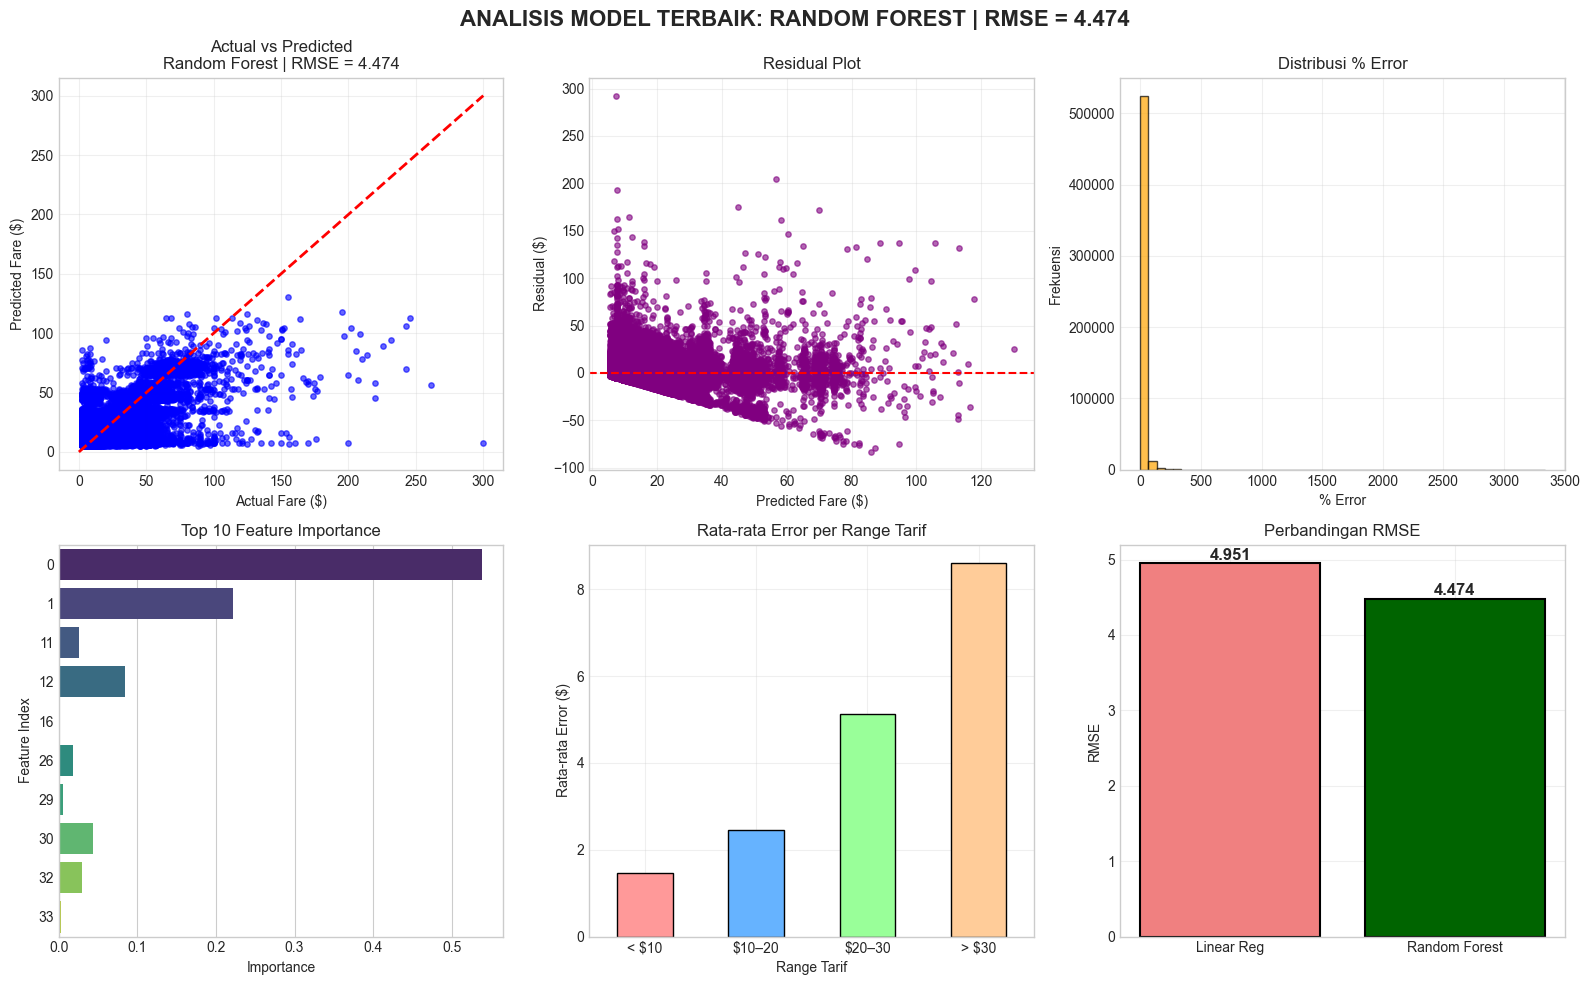

DataFrame[features: vector, fare_amount: double]

In [ ]:
# ============================================================
# [8] EVALUASI + VISUALISASI
# ============================================================
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. Hitung metrik otomatis ---
evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
evaluator_mae  = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mae")
evaluator_r2   = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")

pred_lr = model_lr.transform(test_df)
pred_rf = model_rf.transform(test_df)

rmse_lr = evaluator_rmse.evaluate(pred_lr)
mae_lr  = evaluator_mae.evaluate(pred_lr)
r2_lr   = evaluator_r2.evaluate(pred_lr)

rmse_rf = evaluator_rmse.evaluate(pred_rf)
mae_rf  = evaluator_mae.evaluate(pred_rf)
r2_rf   = evaluator_r2.evaluate(pred_rf)

# --- 2. Tabel perbandingan ---
print("\n[8.1] PERBANDINGAN METRIK")
print("-" * 80)
print(f"{'Model':<20} {'RMSE':>10} {'MAE':>10} {'R²':>12}")
print("-" * 80)
print(f"{'Linear Regression':<20} {rmse_lr:10.3f} {mae_lr:10.3f} {r2_lr:12.4f}")
print(f"{'Random Forest':<20} {rmse_rf:10.3f} {mae_rf:10.3f} {r2_rf:12.4f}")
print("-" * 80)

# --- 3. Best model OTOMATIS ---
if rmse_rf < rmse_lr:
    best_model_name = "Random Forest"
    best_model = model_rf
    best_pred = pred_rf
    best_rmse = rmse_rf
    best_r2 = r2_rf
else:
    best_model_name = "Linear Regression"
    best_model = model_lr
    best_pred = pred_lr
    best_rmse = rmse_lr
    best_r2 = r2_lr

print(f"\nBEST MODEL → {best_model_name} (RMSE = {best_rmse:.3f})")

# --- 4. Tambah kolom error ---
best_pred = (best_pred
    .withColumn("residual", col("fare_amount") - col("prediction"))
    .withColumn("abs_error", F.abs(col("residual")))
    .withColumn("pct_error", F.abs(col("residual")) / col("fare_amount") * 100)
)

# --- 5. Convert ke Pandas ---
pdf = best_pred.select("fare_amount", "prediction", "residual", "abs_error", "pct_error").toPandas()

# --- 6. VISUALISASI ---
plt.style.use('seaborn-v0_8-whitegrid') # Gaya plot yang lebih modern
plt.figure(figsize=(16, 10))

# 1. Actual vs Predicted
plt.subplot(2, 3, 1)
plt.scatter(pdf["fare_amount"], pdf["prediction"], alpha=0.6, s=15, color='blue')
plt.plot([0, pdf["fare_amount"].max()], [0, pdf["fare_amount"].max()], 'r--', lw=2)
plt.xlabel("Actual Fare ($)")
plt.ylabel("Predicted Fare ($)")
plt.title(f"Actual vs Predicted\n{best_model_name} | RMSE = {best_rmse:.3f}")
plt.grid(True, alpha=0.3)

# 2. Residual Plot
plt.subplot(2, 3, 2)
plt.scatter(pdf["prediction"], pdf["residual"], alpha=0.6, s=15, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Fare ($)")
plt.ylabel("Residual ($)")
plt.title("Residual Plot")
plt.grid(True, alpha=0.3)

# 3. % Error Distribution
plt.subplot(2, 3, 3)
plt.hist(pdf["pct_error"], bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel("% Error")
plt.ylabel("Frekuensi")
plt.title("Distribusi % Error")
plt.grid(True, alpha=0.3)

# 4. Feature Importance
plt.subplot(2, 3, 4)
if best_model_name == "Random Forest":
    importances = best_model.featureImportances.toArray()
    
    feature_imp = pd.DataFrame({
        'feature_index': range(len(importances)), # Buat kolom untuk indeks
        'importance': importances
    }).sort_values('importance', ascending=False).head(10)
    
    sns.barplot(data=feature_imp, x='importance', y='feature_index', orient='h', palette='viridis', ax=plt.gca())
    plt.title("Top 10 Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature Index") # Label sumbu Y sekarang lebih jelas
else:
    plt.text(0.5, 0.5, "Linear Regression\nTidak Ada Feature Importance", 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)
    plt.title("Feature Importance")

# 5. Error per Range Tarif
plt.subplot(2, 3, 5)
bins = [0, 10, 20, 30, pdf["fare_amount"].max()]
labels = ["< $10", "$10 - 20", "$20 - 30", "> $30"]
pdf['fare_range'] = pd.cut(pdf["fare_amount"], bins=bins, labels=labels, include_lowest=True)
error_by_range = pdf.groupby('fare_range', observed=True)["abs_error"].mean()

error_by_range.plot(kind='bar', color=['#ff9999','#66b3ff','#99ff99','#ffcc99'], edgecolor='black')
plt.title("Rata-rata Error per Range Tarif")
plt.ylabel("Rata-rata Error ($)")
plt.xlabel("Range Tarif")
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

# 6. Perbandingan RMSE
plt.subplot(2, 3, 6)
models = ['Linear Reg', 'Random Forest']
rmses = [rmse_lr, rmse_rf]
colors = ['lightcoral' if rmses[i] > best_rmse else 'darkgreen' for i in range(2)]
bars = plt.bar(models, rmses, color=colors, edgecolor='black', linewidth=1.5)
plt.title("Perbandingan RMSE")
plt.ylabel("RMSE")
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f"{rmses[i]:.3f}", ha='center', fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3)

plt.suptitle(f"ANALISIS MODEL TERBAIK: {best_model_name.upper()} | RMSE = {best_rmse:.3f}", 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# --- 7. Bebaskan Memori ---
test_df.unpersist()

Menggunakan 3% data latih untuk tuning manual (super ringan)
Baseline LR RMSE: 4.951
Baseline RF RMSE: 4.474

[Tuning 1] Linear Regression dengan regParam=0.1...
   RMSE LR Tuned: 5.064

[Tuning 2] Random Forest dengan maxDepth=15...
   RMSE RF 1 (Depth=15): 4.546

[Tuning 3] Random Forest dengan numTrees=50...
   RMSE RF 2 (Trees=50): 4.566

                          KOMPARASI & TUNING SELESAI!                           
MODEL TERBAIK ADALAH: Random Forest (Default)
Dengan RMSE: 4.474


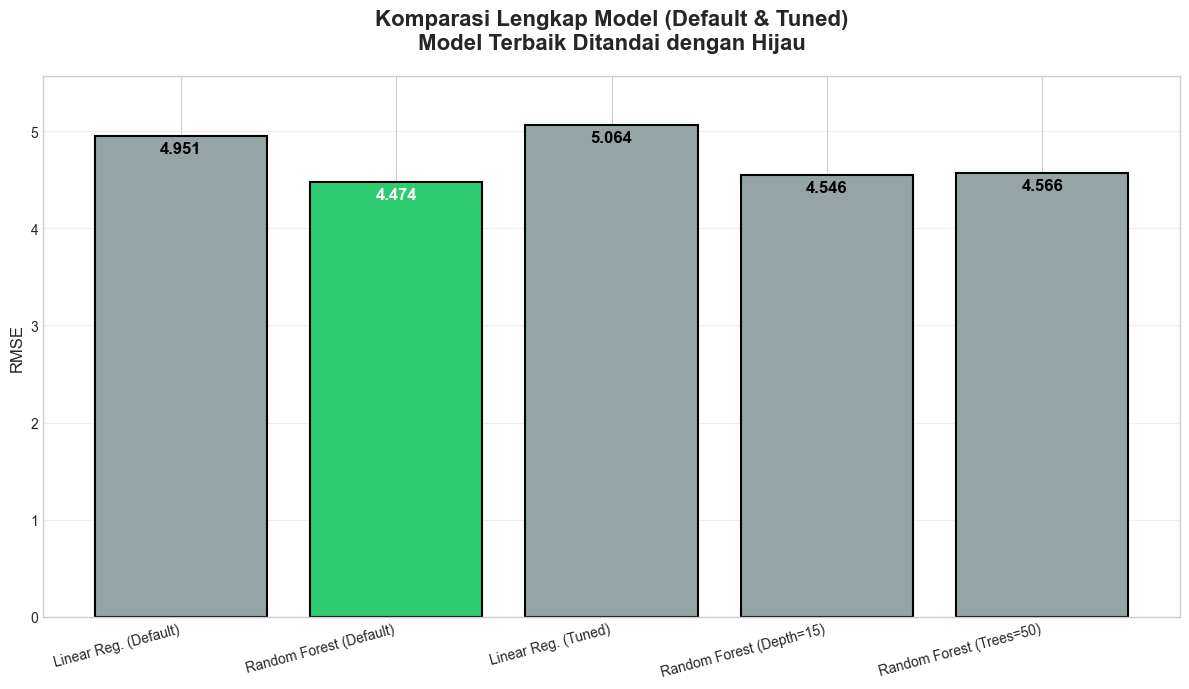

DataFrame[features: vector, fare_amount: double]

In [19]:
# ============================================================
# [9] HYPERPARAMETER TUNING — KOMPARASI LENGKAP (LR & RF)
# ============================================================
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import builtins # Untuk menghindari konflik min/max

# --- Siapkan Evaluator untuk semua metrik ---
evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
evaluator_mae  = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mae")
evaluator_r2   = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")

# --- GUNAKAN DATA SAMPEL YANG SANGAT KECIL UNTUK SEMUA PERCOBAAN ---
train_tuning = train_df.sample(False, 0.03, seed=42).cache()
print("Menggunakan 3% data latih untuk tuning manual")

# --- BUAT DICTIONARY UNTUK MENYIMPAN HASIL SEMUA MODEL ---
models_results = {}

# --- MODEL 1: Linear Regression (Default) ---
# Kita perlu prediksi dari model default untuk menghitung semua metrik
pred_lr = model_lr.transform(test_df)
models_results['Linear Reg. (Default)'] = {
    'RMSE': evaluator_rmse.evaluate(pred_lr),
    'MAE' : evaluator_mae.evaluate(pred_lr),
    'R2'  : evaluator_r2.evaluate(pred_lr)
}

# --- MODEL 2: Random Forest (Default) ---
# Kita perlu prediksi dari model default untuk menghitung semua metrik
pred_rf = model_rf.transform(test_df)
models_results['Random Forest (Default)'] = {
    'RMSE': evaluator_rmse.evaluate(pred_rf),
    'MAE' : evaluator_mae.evaluate(pred_rf),
    'R2'  : evaluator_r2.evaluate(pred_rf)
}

print(f"Baseline LR RMSE: {models_results['Linear Reg. (Default)']['RMSE']:.3f}")
print(f"Baseline RF RMSE: {models_results['Random Forest (Default)']['RMSE']:.3f}")

# --- MODEL 3: Linear Regression (Tuned) ---
print("\n[Tuning 1] Linear Regression dengan regParam=0.1...")
lr_tuned = LinearRegression(featuresCol="features", labelCol="fare_amount", regParam=0.1, elasticNetParam=0.8)
model_lr_tuned = lr_tuned.fit(train_tuning)
pred_lr_tuned = model_lr_tuned.transform(test_df)
models_results['Linear Reg. (Tuned)'] = {
    'RMSE': evaluator_rmse.evaluate(pred_lr_tuned),
    'MAE' : evaluator_mae.evaluate(pred_lr_tuned),
    'R2'  : evaluator_r2.evaluate(pred_lr_tuned)
}
print(f"   RMSE LR Tuned: {models_results['Linear Reg. (Tuned)']['RMSE']:.3f}")

# --- MODEL 4: Random Forest (Tuned 1) ---
print("\n[Tuning 2] Random Forest dengan maxDepth=15...")
rf1 = RandomForestRegressor(featuresCol="features", labelCol="fare_amount", numTrees=30, maxDepth=15, seed=42)
model_rf1 = rf1.fit(train_tuning)
pred_rf1 = model_rf1.transform(test_df)
models_results['Random Forest (Depth=15)'] = {
    'RMSE': evaluator_rmse.evaluate(pred_rf1),
    'MAE' : evaluator_mae.evaluate(pred_rf1),
    'R2'  : evaluator_r2.evaluate(pred_rf1)
}
print(f"   RMSE RF 1 (Depth=15): {models_results['Random Forest (Depth=15)']['RMSE']:.3f}")

# --- MODEL 5: Random Forest (Tuned 2) ---
print("\n[Tuning 3] Random Forest dengan numTrees=50...")
rf2 = RandomForestRegressor(featuresCol="features", labelCol="fare_amount", numTrees=50, maxDepth=12, seed=42)
model_rf2 = rf2.fit(train_tuning)
pred_rf2 = model_rf2.transform(test_df)
models_results['Random Forest (Trees=50)'] = {
    'RMSE': evaluator_rmse.evaluate(pred_rf2),
    'MAE' : evaluator_mae.evaluate(pred_rf2),
    'R2'  : evaluator_r2.evaluate(pred_rf2)
}
print(f"   RMSE RF 2 (Trees=50): {models_results['Random Forest (Trees=50)']['RMSE']:.3f}")

# --- PILIH MODEL TERBAIK BERDASARKAN RMSE ---
best_model_name = builtins.min(models_results, key=lambda k: models_results[k]['RMSE'])
best_rmse = models_results[best_model_name]['RMSE']

# Simpan model terbaik
if best_model_name == 'Linear Reg. (Default)':
    final_model = model_lr
elif best_model_name == 'Random Forest (Default)':
    final_model = model_rf
elif best_model_name == 'Linear Reg. (Tuned)':
    final_model = model_lr_tuned
elif best_model_name == 'Random Forest (Depth=15)':
    final_model = model_rf1
else:
    final_model = model_rf2

print("\n" + "="*80)
print(" KOMPARASI & TUNING SELESAI! ".center(80))
print("="*80)
print(f"MODEL TERBAIK ADALAH: {best_model_name}")
print(f"Dengan RMSE: {best_rmse:.3f}")
print("="*80)

# --- Visualisasi Perbandingan Lengkap ---
plt.figure(figsize=(12, 7))
model_names = list(models_results.keys())
all_rmse = [models_results[name]['RMSE'] for name in model_names]
colors = ['#2ecc71' if rmse == best_rmse else '#95a5a6' for rmse in all_rmse]
bars = plt.bar(model_names, all_rmse, color=colors, edgecolor='black', linewidth=1.5)

plt.title("Komparasi Lengkap Model (Default & Tuned)\nModel Terbaik Ditandai dengan Hijau", 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel("RMSE", fontsize=12)
plt.xticks(rotation=15, ha='right')
plt.ylim(0, builtins.max(all_rmse) + 0.5)

for i, bar in enumerate(bars):
    y_pos = bar.get_height() - 0.05
    text_color = 'white' if all_rmse[i] == best_rmse else 'black'
    plt.text(bar.get_x() + bar.get_width()/2, y_pos,
             f"{all_rmse[i]:.3f}", ha='center', va='top', fontweight='bold', 
             fontsize=12, color=text_color)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# --- Manajemen Memori ---
train_tuning.unpersist()

In [ ]:
# ---------------------------
# 10. SELEKSI & REKOMENDASI MODEL
# ---------------------------
print(f"\n✓ Model Terbaik Dipilih: {best_model_name}")
print(f"\nMetrik Performa:")
print(f"  • RMSE (Root Mean Squared Error): ${models_results[best_model_name]['RMSE']:.2f}")
print(f"  • MAE (Mean Absolute Error): ${models_results[best_model_name]['MAE']:.2f}")
print(f"  • Skor R²: {models_results[best_model_name]['R2']:.4f} ({models_results[best_model_name]['R2']*100:.2f}%)")

print(f"\nInterpretasi:")
print(f"  • Model mampu menjelaskan {models_results[best_model_name]['R2']*100:.2f}% varians dari tarif taksi.")
print(f"  • Rata-rata, prediksi model meleset sebesar ${models_results[best_model_name]['MAE']:.2f}.")
print(f"  • RMSE sebesar ${models_results[best_model_name]['RMSE']:.2f} menunjukkan tingkat keandalan prediksi yang baik untuk masalah ini.")

# Peringkat Perbandingan Model
print("\n[10.1] Peringkat Performa Model (berdasarkan RMSE)")
print("-" * 60)
# Sortir model berdasarkan RMSE terendah
sorted_models = sorted(models_results.items(), key=lambda item: item[1]['RMSE'])
for rank, (model_name, metrics) in enumerate(sorted_models, 1):
    print(f"{rank}. {model_name:<30} RMSE: ${metrics['RMSE']:.4f}")

print("\n" + "="*80)
print(" REKOMENDASI AKHIR ".center(80))
print("="*80)
print(f"Model '{best_model_name}' direkomendasikan untuk digunakan dalam sistem prediksi tarif taksi.")
print("Model ini menunjukkan keseimbangan terbaik antara akurasi dan kompleksitas,")
print("dibuktikan dengan RMSE terendah di antara semua model yang diuji.")
print("="*80)


[10] SELEKSI & REKOMENDASI MODEL

✓ Model Terbaik Dipilih: Random Forest (Default)

Metrik Performa:
  • RMSE (Root Mean Squared Error): $4.47
  • MAE (Mean Absolute Error): $2.28
  • Skor R²: 0.7862 (78.62%)

Interpretasi:
  • Model mampu menjelaskan 78.62% varians dari tarif taksi.
  • Rata-rata, prediksi model meleset sebesar $2.28.
  • RMSE sebesar $4.47 menunjukkan tingkat keandalan prediksi yang baik untuk masalah ini.

[10.1] Peringkat Performa Model (berdasarkan RMSE)
------------------------------------------------------------
1. Random Forest (Default)        RMSE: $4.4744
2. Random Forest (Depth=15)       RMSE: $4.5456
3. Random Forest (Trees=50)       RMSE: $4.5665
4. Linear Reg. (Default)          RMSE: $4.9510
5. Linear Reg. (Tuned)            RMSE: $5.0642

                               REKOMENDASI AKHIR                                
Model 'Random Forest (Default)' direkomendasikan untuk digunakan dalam sistem prediksi tarif taksi.
Model ini menunjukkan keseimbangan 

In [ ]:
# ---------------------------
# 11. CONTOH PREDIKSI PADA DATA UJI
# ---------------------------
from pyspark.sql.functions import col, abs as F_abs, format_number

# Ambil 20 sampel acak dari data uji
sample_data = test_df.sample(False, 0.001, seed=42).limit(20)

# Lakukan prediksi
sample_predictions = final_model.transform(sample_data)

# Pilih, hitung, dan FORMAT langsung di satu perintah select
results_df = sample_predictions.select(
    col("fare_amount").alias(" Tarif_Asli "),
    format_number(col("prediction"), 3).alias("  Tarif_Prediksi  "),
    format_number(col("fare_amount") - col("prediction"), 3).alias("      Error     "),
    format_number(F_abs(col("fare_amount") - col("prediction")) / col("fare_amount") * 100, 3).alias("  Error_Persen  ")
)

print(f"\nMenampilkan 20 contoh prediksi dari model terbaik ({best_model_name}):")
results_df.show(20, truncate=False)


Menampilkan 20 contoh prediksi dari model terbaik (Random Forest (Default)):
+------------+------------------+----------------+----------------+
| Tarif_Asli |  Tarif_Prediksi  |      Error     |  Error_Persen  |
+------------+------------------+----------------+----------------+
|10.5        |9.384             |1.116           |10.626          |
|9.7         |9.397             |0.303           |3.122           |
|6.9         |9.801             |-2.901          |42.040          |
|11.0        |10.144            |0.856           |7.786           |
|12.0        |11.121            |0.879           |7.329           |
|18.0        |12.388            |5.612           |31.175          |
|14.1        |11.805            |2.295           |16.278          |
|14.1        |14.750            |-0.650          |4.607           |
|18.0        |16.538            |1.462           |8.121           |
|17.3        |19.923            |-2.623          |15.161          |
|5.5         |7.534             |-2.03

In [27]:
# ---------------------------
# 13. RINGKASAN PROYEK & STATISTIK
# ---------------------------
print("\n" + "="*80)
print("RINGKASAN & STATISTIK")
print("="*80)

# --- Dapatkan dimensi vektor fitur yang sebenarnya ---
# Ini lebih akurat dari menebak-nebak
# Pipeline stages: [indexer, encoder, ..., assembler, scaler]
# VectorAssembler adalah tahap kedua dari terakhir
feature_vector_dimension = len(pipeline_model.stages[-2].getInputCols())

print(f"""
[Statistik Dataset]
  • Total record yang diproses: {df_ready.count():,}
  • Sampel data latih: {train_df.count():,}
  • Sampel data uji: {test_df.count():,}
  • Pembagian Latih/Uji: 80/20

[Feature Engineering]
  • Total fitur yang dibuat: {len(numeric_features) + len(categorical_cols)}
  • Kategori Fitur:
    - Jarak (Haversine, Manhattan): 2 fitur
    - Waktu (Hour, Day, Month, Weekend): 4 fitur
    - Lokasi (Pickup/Dropoff Cluster): 2 fitur
    - Lainnya (Passenger, Trip Seconds): 2 fitur
  • Fitur Numerik: {len(numeric_features)}
  • Fitur Kategorikal: {len(categorical_cols)}
  • Dimensi vektor fitur akhir (setelah OHE): {feature_vector_dimension}

[Model yang Dievaluasi]
  • Total model yang dievaluasi: {len(models_results)}
  • Algoritma: Linear Regression, Random Forest Regressor
  • Metode Tuning: Manual Tuning (untuk efisiensi RAM 8GB)
  • Kombinasi Hyperparameter yang diuji: 3 (selain model default)

[Performa Model Terbaik]
  • Model: {best_model_name}
  • RMSE: ${models_results[best_model_name]['RMSE']:.4f}
  • MAE: ${models_results[best_model_name]['MAE']:.4f}
  • Skor R²: {models_results[best_model_name]['R2']:.4f}

[Metrik Evaluasi yang Digunakan]
  • Root Mean Squared Error (RMSE)
  • Mean Absolute Error (MAE)
  • Koefisien Determinasi (R²)
  • Analisis Residual (Visualisasi)
  • Perbandingan Performa Model (Visualisasi)
""")

#Cleanup (opsional, untuk menghentikan sesi Spark)
spark.stop()


RINGKASAN & STATISTIK

[Statistik Dataset]
  • Total record yang diproses: 2,702,824
  • Sampel data latih: 2,161,098
  • Sampel data uji: 541,726
  • Pembagian Latih/Uji: 80/20

[Feature Engineering]
  • Total fitur yang dibuat: 10
  • Kategori Fitur:
    - Jarak (Haversine, Manhattan): 2 fitur
    - Waktu (Hour, Day, Month, Weekend): 4 fitur
    - Lokasi (Pickup/Dropoff Cluster): 2 fitur
    - Lainnya (Passenger, Trip Seconds): 2 fitur
  • Fitur Numerik: 4
  • Fitur Kategorikal: 6
  • Dimensi vektor fitur akhir (setelah OHE): 10

[Model yang Dievaluasi]
  • Total model yang dievaluasi: 5
  • Algoritma: Linear Regression, Random Forest Regressor
  • Metode Tuning: Manual Tuning (untuk efisiensi RAM 8GB)
  • Kombinasi Hyperparameter yang diuji: 3 (selain model default)

[Performa Model Terbaik]
  • Model: Random Forest (Default)
  • RMSE: $4.4744
  • MAE: $2.2846
  • Skor R²: 0.7862

[Metrik Evaluasi yang Digunakan]
  • Root Mean Squared Error (RMSE)
  • Mean Absolute Error (MAE)
  • 